<a href="https://colab.research.google.com/github/cc-ca/projet-impression-3d/blob/dev/Entrainement_binaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet de détection de défaut en impression 3d

Ce projet a pour but de faire de la détection de défaut pendant une impression 3d.<br><br>
Le but est d'éviter le gachis de bobines plastiques et non de garantir une impression parfaite. En effet dans de nombreux cas des defauts superficiels ne rendent pas inutilisables les pièces imprimées.<br><br>
C'est pourquoi nous concentrerons sur les gros défaut qui peuvent venir abimer l'imprimante en plus de gacher du plastique et de l'énergie.<br><br>
Nous cherchons donc à faire un modèle capable de classifier à partir d'une image la catégorie de l'impression entre pas de défaut, pièce décollée du plateau, et défaut spaghetti.

##Imports préliminaires (librairies et dataset)

In [1]:
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
import time

Pour ce projet nous avons utilisé comme base un dataset trouvé sur kaggle ([Lien Dataset Kaggle](https://www.kaggle.com/datasets/mikulhe/3d-printing-errors/)). <br>Nous n'avons gardé que les catégories qui nous intéressent et l'avons enrichi de données que nous avons crées en prenant des photos des imprimantes 3d de l'ISEN.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
# On se déplace dans notre espace de travail.
# Prévoir le dossier où se placer ou modifier le chemin ci-dessous.
%cd "/content/gdrive/MyDrive/projet impression 3d"

/content/gdrive/MyDrive/projet impression 3d


Faites un raccourcis du dataset dans le dossier correspondant au chemin ci-dessus:

[Lien Google Drive du dataset](https://drive.google.com/drive/folders/1y6OoWPs9WjeynMaLI7R-NipD_thyCNjw?usp=sharing)

# Préparation des données

In [4]:
dataset_path = 'dataset_binaire_sansbed' # Chemin du dataset par rapport à l'espace de travail (par defaut: projet impression 3d)
RESIZE_SIZE = (255, 255)       # Résolution sous laquelle les images sont redimensionné en entrée du modèle

In [5]:
def load_data(dataset_path):
    data = [] # Liste des images contenu dans dataset_path
    labels = [] # Liste des labels de chaque image

    # Pour chaque image contenu dans dataset_path,
    # l'importe puis la prépare pour l'entrainement
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            label = folder.lower()   # Utilisez le nom du dossier comme label
            print(label)

            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, RESIZE_SIZE) # Force la taille d'une image pour qu'elle corresponde à celle utilisée lors de l'entraînement
                data.append(img)
                labels.append(label)

    data = np.array(data) / 255.0    # Normalisez les valeurs des pixels
    labels = np.array(labels)

    return data, labels

In [6]:
def shuffle_data(data, labels):
    combined_data = list(zip(data,labels))

    # Mélange les données
    random.shuffle(combined_data)

    # Divisez à nouveau la liste combinée en deux listes distinctes
    data,labels = zip(*combined_data)

    labels = np.array(labels)
    data = np.array(data)

    return data, labels

In [7]:
data, labels = load_data(dataset_path)

0
1


In [8]:
# On défini un dictionnaire de mapping (catégorie -> numéro) pour chaque labels précédement listé
categorie_mapping = {
    "0": 0,
    "1": 1,

}

# Utiliser NumPy pour convertir les catégories en numéros
labels = np.array([categorie_mapping[c] for c in labels])

In [9]:
print('Taille du dataset: ', len(labels))
print('Catégorie de la dernière image: ', labels[-1])

Taille du dataset:  362
Catégorie de la dernière image:  1


In [10]:
data, labels = shuffle_data(data, labels)

In [11]:
print('Taille du dataset: ', len(labels))
print('Catégorie de la dernière image: ', labels[-1])

Taille du dataset:  362
Catégorie de la dernière image:  1


# Création du modèle

In [25]:
drop_out = 0.3
model = keras.Sequential([
    keras.layers.Conv2D(32, (8,8), activation='relu', input_shape=(*RESIZE_SIZE, 1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (4,4), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The third convolution
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),



    # Flatten the results to feed into a DNN
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    layers.Dropout(drop_out),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),

    layers.Dense(len(categorie_mapping), activation='softmax')
])

# Compilez le modèle
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 248, 248, 32)      2080      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 124, 124, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 121, 121, 64)      32832     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 60, 60, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 29, 29, 64)       

In [26]:
from keras.callbacks import ModelCheckpoint

# Décommenter la ligne ci-dessous pour sauvegarder le meilleur modèle. (Attention assez lourd !)
#checkpoint = ModelCheckpoint('meilleur_modele.h5', monitor='val_accuracy', save_best_only=True)

In [27]:
# Entraine le modèle.
# Décommenter la ligne correspondante pour sauvegarder ou non le meilleur modèle. (voir la cellule précédente)
model.fit(data, labels, epochs=30, validation_split=0.1, batch_size=8)
#model.fit(data, labels, epochs=100, validation_split=0.20, batch_size=8, callbacks=[checkpoint])

Epoch 1/30
41/41 [==============================] - 4s 46ms/step - loss: 0.7194 - accuracy: 0.5231 - val_loss: 0.6979 - val_accuracy: 0.3243
Epoch 2/30
41/41 [==============================] - 1s 18ms/step - loss: 0.6941 - accuracy: 0.5231 - val_loss: 0.7046 - val_accuracy: 0.3243
Epoch 3/30
41/41 [==============================] - 1s 18ms/step - loss: 0.6987 - accuracy: 0.5231 - val_loss: 0.7022 - val_accuracy: 0.3243
Epoch 4/30
41/41 [==============================] - 1s 18ms/step - loss: 0.6933 - accuracy: 0.5231 - val_loss: 0.7005 - val_accuracy: 0.3243
Epoch 5/30
41/41 [==============================] - 1s 18ms/step - loss: 0.6929 - accuracy: 0.5231 - val_loss: 0.7118 - val_accuracy: 0.3243
Epoch 6/30
41/41 [==============================] - 1s 19ms/step - loss: 0.6908 - accuracy: 0.5262 - val_loss: 0.7257 - val_accuracy: 0.3243
Epoch 7/30
41/41 [==============================] - 1s 18ms/step - loss: 0.7153 - accuracy: 0.5200 - val_loss: 0.7082 - val_accuracy: 0.3243
Epoch 8/30
41

On sauvegarde les meilleurs poids pour le modèle dans ce dossier Google Drive:

[Lien du Google Drive des modèles sauvegardé](https://drive.google.com/drive/folders/124cj4R3cZ6kY-yXq6uaot2LCysKZWUJ8?usp=drive_link)

# Prédiction

In [28]:
def predict_defect(model, image_path):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)

    # Interprétez les prédictions
    class_labels = list(categorie_mapping.keys())
    predicted_class = class_labels[np.argmax(predictions)]

    return predicted_class

In [29]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, RESIZE_SIZE) # Force la taille d'une image pour qu'elle corresponde à celle utilisée lors de l'entraînement
    img = img / 255.0                  # Normalisez les valeurs des pixels
    img = np.expand_dims(img, axis=0)  # Ajoutez une dimension pour représenter le lot (batch)

    return img

In [30]:
def predict(dir,target):
    print(dir)
    """ Affiche les prédictions pour l'ensemble des images d'un dossier
    """
    resultf=""
    nb_total=0
    nb_positif=0

    for filename in os.listdir(dir):
        nb_total+=1

        result = predict_defect(model, dir +"/" + filename)
        if result==target:
            nb_positif+=1

        resultf= resultf + "prédiction pour"+ filename + " : "+ str(result) +"\n"

    print(resultf)
    print(str((nb_positif*100)/nb_total) + " % de précision")


In [31]:
from PIL import Image
import matplotlib.pyplot as plt

def vignette_random(dir):
    """ Affiche la prédiction pour un image au hasard dans un dossier donné
    """
    L=[]

    # Choisi une image au hasard parmis les images d'un dossier
    for filename in os.listdir(dir):
        L.append(filename)
    file_alea = L[random.randint(0, (len(L)-1))]

    image_path = dir +"/" + file_alea
    result = predict_defect(model, image_path)

    # Affiche la vignette et sa prédiction
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print (result)


In [32]:
predict("testok","0")

testok
1/1 [==============================] - 0s 17ms/step
prédiction pourNoDefects.183.jpg : 0
prédiction pourNoDefects.29.jpg : 0
prédiction pourIMG_20231018_115617.jpg : 0
prédiction pourIMG_20231017_174742.jpg : 1
prédiction pour20231023_112611.jpg : 1
prédiction pour20231023_112603.jpg : 0
prédiction pour20231024_143239.jpg : 1
prédiction pour20231024_143230.jpg : 0
prédiction pour20231024_154352.jpg : 0
prédiction pour20231024_154325.jpg : 0
prédiction pourIMG_20231024_145632.jpg : 0
prédiction pourIMG_20231024_144829.jpg : 0
prédiction pour416686302_692845809500317_8210388049984641450_n.jpg : 1
prédiction pour20240110_134553.jpg : 1
prédiction pour20240110_144254.jpg : 1
prédiction pour20240110_152928.jpg : 0

62.5 % de précision


In [33]:
predict("testspaghetti","1")

testspaghetti
1/1 [==============================] - 0s 17ms/step
prédiction pour1e0889f0d3cb71fe1a1dc15a23bcda8cf78d4241.jpg : 1
prédiction pourspaghetti_91_jpg.rf.2b147f68c7718049a4c11374c5f190be.jpg : 1
prédiction pourimag-12-_jpg.rf.30b4d2d01cbe881c76ffb7cd4aa30d4c.jpg : 1
prédiction pourimag-74-_jpg.rf.bde89b1dfa1f343163a56c9b2730ca12.jpg : 1
prédiction pourff5iwd4fixs51_jpg.rf.bf5c0cf1f11c7afc4c230ecf34566916.jpg : 1
prédiction pourze6lxm6eqc171_2_jpg.rf.2c7f4556435975daac73a70a006968df.jpg : 1
prédiction pourultiprint7_jpg.rf.217c5c6d85353882eca3a8933019da20.jpg : 1
prédiction pour20240110_134312.jpg : 1
prédiction pour20240110_134319.jpg : 0
prédiction pour20240109_114202.jpg : 1

90.0 % de précision


In [34]:
predict("testbed_not_stick","1")

testbed_not_stick
1/1 [==============================] - 0s 20ms/step
prédiction pourmirror_20231020_154642.jpg : 0
prédiction pourmirror_20231020_154647.jpg : 1
prédiction pourmirror_20231020_154657.jpg : 0
prédiction pourmirror_20231023_113042.jpg : 0
prédiction pourmirror_20231023_113059.jpg : 0
prédiction pourmirror_20231023_113114.jpg : 0
prédiction pourmirror_20231024_145033.jpg : 0
prédiction pourmirror_20231024_145036.jpg : 1
prédiction pourmirror_20231024_145045.jpg : 1
prédiction pourmirror_20231024_145048.jpg : 0
prédiction pourmirror_20231024_145054.jpg : 1
prédiction pourmirror_IMG_20231017_174752.jpg : 0
prédiction pourmirror_IMG_20231024_145904.jpg : 0
prédiction pourmirror_IMG_20231024_145911.jpg : 1
prédiction pourmirror_Screenshot_3.jpg : 0
prédiction pourmirror_Screenshot_4.jpg : 1

37.5 % de précision


1/1 [==============================] - 0s 17ms/step


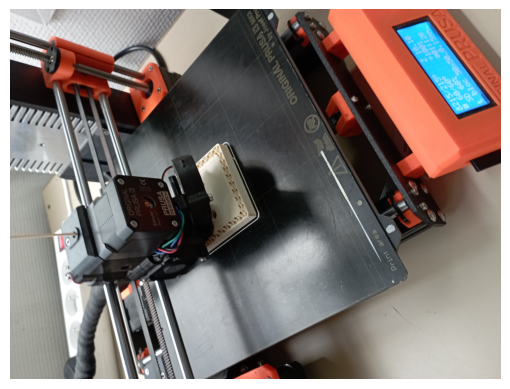

0


In [35]:
vignette_random("testok")

1/1 [==============================] - 0s 32ms/step


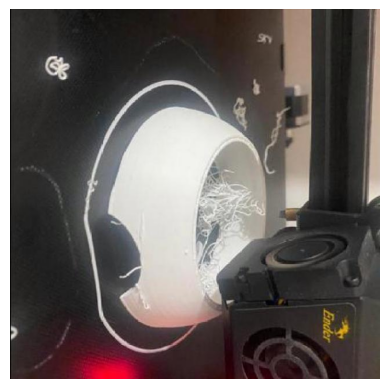

1


In [36]:
vignette_random("testspaghetti")

Après avoir entrainé notre modèle sur google collab nous avons fait un deuxième notebook pour le charger et l'utiliser avec une webcam en direct sur un ordinateur.

In [37]:
# Décommenter pour sauvegarde le modèle actuel
#model.save('model 90 80 25.h5')